# 03: Batch Size Benchmark (bf16)

**Question:** How does batch size affect training speed?

We measure two things:
1. **Tokens/sec** — how fast we burn through training data
2. **Steps/sec** — how many gradient updates (weight snapshots) we get per unit time

These trade off against each other. Bigger batches process more tokens per step but take longer per step. This notebook just reports the measurements—the right batch size depends on what we're optimizing for.

**Note:** We train in bfloat16 to match Qwen 3 4B's training regime. On MPS, PyTorch upcasts to float32 for compute and downcasts for storage—same math, but with bf16 quantization on weights.

## Parameters

In [ ]:
# === Parameters ===

# Paths
DATA_DIR = "data"
TOKENIZER_PATH = f"{DATA_DIR}/tokenizer.json"
TOKENS_PATH = f"{DATA_DIR}/model_corpus_tokens.safetensors"

# Model architecture (baseline: "Balanced" from README)
N_LAYERS = 3
D_MODEL = 96
N_HEADS = 2
D_FF = D_MODEL * 2  # 2x FFN ratio
SEQ_LEN = 128
DROPOUT = 0.0  # No dropout for benchmarking

# Training - extended range to find where efficiency actually drops
BATCH_SIZES = [1, 2, 4, 8, 16, 32, 64, 128, 256]
WARMUP_STEPS = 10   # Discard first N steps (JIT compilation, etc.)
BENCHMARK_STEPS = 100  # Steps to time
LEARNING_RATE = 1e-3

# Precision: bf16 to match Qwen 3 4B training regime
# On MPS, this upcasts for compute and downcasts for storage
import torch
MODEL_DTYPE = torch.bfloat16

# Reproducibility
RANDOM_SEED = 42

## Imports & Device

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tokenizers import Tokenizer
import time
import math
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

## Load Tokenizer & Corpus

In [ ]:
# Load tokenizer
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Loaded tokenizer: {vocab_size:,} tokens")

# Load cached tokenized corpus (fast!)
print(f"Loading cached tokens from {TOKENS_PATH}...")
tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

## Dataset

In [4]:
class TokenDataset(Dataset):
    """Simple dataset that returns random chunks of tokens."""
    
    def __init__(self, tokens: torch.Tensor, seq_len: int, num_samples: int = 100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        # Pre-generate random starting positions for reproducibility
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]  # input, target

# Test it
dataset = TokenDataset(all_tokens, SEQ_LEN)
x, y = dataset[0]
print(f"✓ Dataset ready: {len(dataset):,} samples")
print(f"  Sample shape: x={x.shape}, y={y.shape}")

✓ Dataset ready: 100,000 samples
  Sample shape: x=torch.Size([128]), y=torch.Size([128])


## Minimal GPT Model

A simple decoder-only transformer. Nothing fancy—we just need something that exercises the GPU realistically.

In [5]:
class GPT(nn.Module):
    """Minimal GPT for benchmarking."""
    
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=n_heads,
                dim_feedforward=d_ff,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True  # Pre-LN like modern transformers
            )
            for _ in range(n_layers)
        ])
        
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        
        # Weight tying
        self.head.weight = self.tok_emb.weight
        
        self.seq_len = seq_len
        self.d_model = d_model
        
        # Causal mask (will be created on first forward)
        self.register_buffer('causal_mask', None)
    
    def forward(self, x):
        B, T = x.shape
        
        # Create causal mask if needed
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool),
                diagonal=1
            )
        
        # Embeddings
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        
        # Transformer layers
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        
        # Output
        h = self.ln_f(h)
        logits = self.head(h)
        
        return logits

# Create model in bf16
model = GPT(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    d_ff=D_FF,
    seq_len=SEQ_LEN,
    dropout=DROPOUT
).to(device).to(MODEL_DTYPE)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model created: {n_params:,} parameters ({MODEL_DTYPE})")
print(f"  Architecture: {N_LAYERS}L / {D_MODEL}D / {N_HEADS}H / {D_FF}FF")

✓ Model created: 619,680 parameters (torch.bfloat16)
  Architecture: 3L / 96D / 2H / 192FF


## Benchmark Function

In [6]:
def benchmark_batch_size(model, dataset, batch_size, warmup_steps, benchmark_steps, device):
    """
    Run training steps and measure throughput.
    
    Returns: dict with tokens/sec, steps/sec, time stats
    """
    # Fresh model state for each benchmark
    model.train()
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    loader_iter = iter(loader)
    
    tokens_per_step = batch_size * SEQ_LEN
    
    # Warmup (JIT compilation, memory allocation, etc.)
    for _ in range(warmup_steps):
        try:
            x, y = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            x, y = next(loader_iter)
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
    
    # Sync before timing
    if device == 'mps':
        torch.mps.synchronize()
    elif device == 'cuda':
        torch.cuda.synchronize()
    
    # Timed benchmark
    step_times = []
    
    for _ in range(benchmark_steps):
        try:
            x, y = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            x, y = next(loader_iter)
        
        x, y = x.to(device), y.to(device)
        
        step_start = time.perf_counter()
        
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
        
        # Sync for accurate timing
        if device == 'mps':
            torch.mps.synchronize()
        elif device == 'cuda':
            torch.cuda.synchronize()
        
        step_times.append(time.perf_counter() - step_start)
    
    step_times = np.array(step_times)
    
    return {
        'batch_size': batch_size,
        'tokens_per_step': tokens_per_step,
        'mean_step_time': step_times.mean(),
        'std_step_time': step_times.std(),
        'steps_per_sec': 1.0 / step_times.mean(),
        'tokens_per_sec': tokens_per_step / step_times.mean(),
    }

print(f"✓ Benchmark function ready (model dtype: {MODEL_DTYPE})")

✓ Benchmark function ready (model dtype: torch.bfloat16)


## Run the Sweep

In [7]:
print("="*70)
print("BATCH SIZE SWEEP")
print("="*70)
print(f"Model: {N_LAYERS}L/{D_MODEL}D/{N_HEADS}H, {n_params:,} params")
print(f"Sequence length: {SEQ_LEN}")
print(f"Warmup: {WARMUP_STEPS} steps, Benchmark: {BENCHMARK_STEPS} steps")
print()

results = []

for batch_size in BATCH_SIZES:
    print(f"Batch size {batch_size}...", end=" ", flush=True)
    
    # Clear cache between runs
    if device == 'mps':
        torch.mps.empty_cache()
    elif device == 'cuda':
        torch.cuda.empty_cache()
    
    result = benchmark_batch_size(
        model, dataset, batch_size,
        WARMUP_STEPS, BENCHMARK_STEPS, device
    )
    results.append(result)
    
    print(f"{result['tokens_per_sec']:,.0f} tok/s ({result['steps_per_sec']:.1f} it/s)")

print()
print("✓ Sweep complete")

BATCH SIZE SWEEP
Model: 3L/96D/2H, 619,680 params
Sequence length: 128
Warmup: 10 steps, Benchmark: 100 steps

Batch size 1... 16,591 tok/s (129.6 it/s)
Batch size 2... 35,802 tok/s (139.9 it/s)
Batch size 4... 71,201 tok/s (139.1 it/s)
Batch size 8... 136,638 tok/s (133.4 it/s)
Batch size 16... 260,403 tok/s (127.1 it/s)
Batch size 32... 348,527 tok/s (85.1 it/s)
Batch size 64... 388,943 tok/s (47.5 it/s)
Batch size 128... 403,644 tok/s (24.6 it/s)
Batch size 256... 421,036 tok/s (12.8 it/s)

✓ Sweep complete


## Analyze Results

In [8]:
import pandas as pd

df = pd.DataFrame(results)

# Convert to per-minute for readability
df['tokens_per_min'] = df['tokens_per_sec'] * 60
df['steps_per_min'] = df['steps_per_sec'] * 60

print("Batch Size Benchmark Results")
print("="*70)
print(f"Model: {N_LAYERS}L/{D_MODEL}D/{N_HEADS}H ({n_params:,} params)")
print(f"Sequence length: {SEQ_LEN}")
print("="*70)
print()
print(df[['batch_size', 'tokens_per_step', 'tokens_per_min', 'steps_per_min']].to_string(
    index=False, 
    formatters={
        'batch_size': lambda x: f"{int(x):>5d}",
        'tokens_per_step': lambda x: f"{int(x):>6,d}",
        'tokens_per_min': lambda x: f"{x:>12,.0f}",
        'steps_per_min': lambda x: f"{x:>10,.0f}",
    },
    header=['Batch', 'Tok/Step', 'Tokens/Min', 'Steps/Min']
))
print()

Batch Size Benchmark Results
Model: 3L/96D/2H (619,680 params)
Sequence length: 128

Batch Tok/Step   Tokens/Min  Steps/Min
    1      128      995,446      7,777
    2      256    2,148,123      8,391
    4      512    4,272,074      8,344
    8    1,024    8,198,307      8,006
   16    2,048   15,624,158      7,629
   32    4,096   20,911,649      5,105
   64    8,192   23,336,597      2,849
  128   16,384   24,218,649      1,478
  256   32,768   25,262,160        771



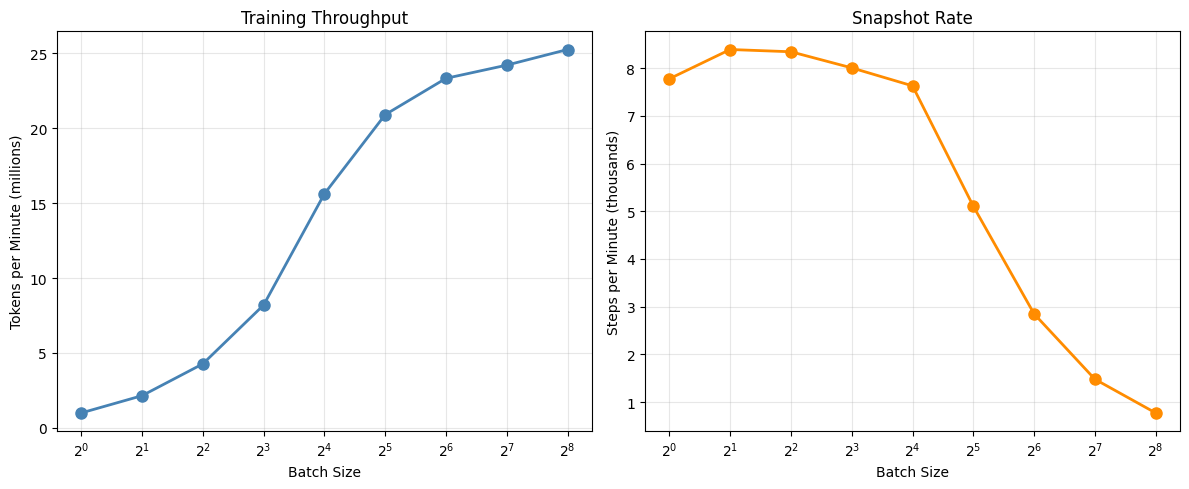

✓ Saved: batch_size_benchmark@200.png, batch_size_benchmark@72.png


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Tokens per minute vs batch size
ax1 = axes[0]
ax1.plot(df['batch_size'], df['tokens_per_min'] / 1e6, 'o-', color='steelblue', linewidth=2, markersize=8)
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Tokens per Minute (millions)')
ax1.set_title('Training Throughput')
ax1.set_xscale('log', base=2)
ax1.grid(True, alpha=0.3)

# 2. Steps per minute vs batch size
ax2 = axes[1]
ax2.plot(df['batch_size'], df['steps_per_min'] / 1000, 'o-', color='darkorange', linewidth=2, markersize=8)
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Steps per Minute (thousands)')
ax2.set_title('Snapshot Rate')
ax2.set_xscale('log', base=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('batch_size_benchmark@200.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.savefig('batch_size_benchmark@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: batch_size_benchmark@200.png, batch_size_benchmark@72.png")

## Summary

In [10]:
# Find the extremes for context
max_throughput_idx = df['tokens_per_min'].idxmax()
max_steps_idx = df['steps_per_min'].idxmax()

print("="*70)
print("BATCH SIZE BENCHMARK COMPLETE (bf16)")
print("="*70)

print(f"\nHardware: {device.upper()}")
print(f"Model: {N_LAYERS}L/{D_MODEL}D/{N_HEADS}H ({n_params:,} params, {MODEL_DTYPE})")

print(f"\nKey findings:")
print(f"  • Peak throughput: {df.loc[max_throughput_idx, 'tokens_per_min']/1e6:.1f}M tokens/min (batch {int(df.loc[max_throughput_idx, 'batch_size'])})")
print(f"  • Peak snapshot rate: {df.loc[max_steps_idx, 'steps_per_min']/1000:.1f}k steps/min (batch {int(df.loc[max_steps_idx, 'batch_size'])})")

print(f"\nThe tradeoff:")
print(f"  • Bigger batches → more tokens/min, fewer steps/min")
print(f"  • Smaller batches → fewer tokens/min, more steps/min")

print(f"\nChoose based on what you need:")
print(f"  • Observing dynamics? Smaller batches = more weight snapshots")
print(f"  • Training fast? Larger batches = more tokens processed")
print("="*70)

BATCH SIZE BENCHMARK COMPLETE (bf16)

Hardware: MPS
Model: 3L/96D/2H (619,680 params, torch.bfloat16)

Key findings:
  • Peak throughput: 25.3M tokens/min (batch 256)
  • Peak snapshot rate: 8.4k steps/min (batch 2)

The tradeoff:
  • Bigger batches → more tokens/min, fewer steps/min
  • Smaller batches → fewer tokens/min, more steps/min

Choose based on what you need:
  • Observing dynamics? Smaller batches = more weight snapshots
  • Training fast? Larger batches = more tokens processed


In [11]:
# Normalize both metrics to [0, 1] and look at their product
# High product = good at both things

df['throughput_norm'] = df['tokens_per_min'] / df['tokens_per_min'].max()
df['snapshot_norm'] = df['steps_per_min'] / df['steps_per_min'].max()
df['combined_score'] = df['throughput_norm'] * df['snapshot_norm']

print("Combined Score (throughput × snapshot rate, normalized)")
print("="*60)
print(df[['batch_size', 'throughput_norm', 'snapshot_norm', 'combined_score']].to_string(
    index=False,
    formatters={
        'batch_size': lambda x: f"{int(x):>5d}",
        'throughput_norm': lambda x: f"{x:>6.1%}",
        'snapshot_norm': lambda x: f"{x:>6.1%}",
        'combined_score': lambda x: f"{x:>6.3f}",
    },
    header=['Batch', 'Throughput', 'Snapshot', 'Combined']
))

best_idx = df['combined_score'].idxmax()
print(f"\nBest combined score: batch {int(df.loc[best_idx, 'batch_size'])} ({df.loc[best_idx, 'combined_score']:.3f})")

Combined Score (throughput × snapshot rate, normalized)
Batch Throughput Snapshot Combined
    1       3.9%    92.7%    0.037
    2       8.5%   100.0%    0.085
    4      16.9%    99.4%    0.168
    8      32.5%    95.4%    0.310
   16      61.8%    90.9%    0.562
   32      82.8%    60.8%    0.504
   64      92.4%    33.9%    0.314
  128      95.9%    17.6%    0.169
  256     100.0%     9.2%    0.092

Best combined score: batch 16 (0.562)


## The Work Constant

Can we find a general relationship? The GPU is doing work proportional to `params × tokens_per_step` each step, with roughly constant overhead per step. The sweet spot is where work-per-step saturates the GPU without wasting capacity.

Let's compute the "work constant" at our optimal batch size and use it to predict optimal batches for other architectures.

In [12]:
# At the sweet spot (batch 16), compute the work constant
optimal_batch = 16
optimal_tokens_per_step = optimal_batch * SEQ_LEN

work_constant = n_params * optimal_tokens_per_step

print(f"Work Constant Derivation")
print("="*60)
print(f"Model parameters: {n_params:,}")
print(f"Optimal batch size: {optimal_batch}")
print(f"Sequence length: {SEQ_LEN}")
print(f"Tokens per step: {optimal_tokens_per_step:,}")
print()
print(f"Work constant = params × tokens_per_step")
print(f"             = {n_params:,} × {optimal_tokens_per_step:,}")
print(f"             = {work_constant:,.0f}")
print(f"             ≈ {work_constant/1e9:.2f} billion")

Work Constant Derivation
Model parameters: 619,680
Optimal batch size: 16
Sequence length: 128
Tokens per step: 2,048

Work constant = params × tokens_per_step
             = 619,680 × 2,048
             = 1,269,104,640
             ≈ 1.27 billion


In [13]:
# Predict optimal batch sizes for candidate architectures
# Using: optimal_batch = work_constant / (params × seq_len)

def estimate_params(n_layers, d_model, n_heads, d_ff, vocab_size, seq_len):
    """Rough parameter count for a GPT-style model."""
    # Embeddings (token + position, but token is tied to output)
    emb_params = vocab_size * d_model + seq_len * d_model
    
    # Per layer: attention (QKV + out) + FFN (up + down) + 2 layer norms
    attn_params = 4 * d_model * d_model  # Q, K, V, O projections
    ffn_params = 2 * d_model * d_ff       # up and down projections  
    ln_params = 4 * d_model               # 2 layer norms per layer
    layer_params = attn_params + ffn_params + ln_params
    
    # Final layer norm (output head is tied to embeddings)
    final_ln = 2 * d_model
    
    total = emb_params + n_layers * layer_params + final_ln
    return total

# Candidate architectures from README
architectures = [
    ("Lean",     2, 64,  1, 64*2),
    ("Balanced", 3, 96,  2, 96*2),
    ("Rich",     4, 128, 2, 128*2),
]

print("Predicted Optimal Batch Sizes")
print("="*70)
print(f"{'Architecture':<12} {'Params':>10} {'Predicted Batch':>16} {'Tokens/Step':>12}")
print("-"*70)

for name, layers, d_model, heads, d_ff in architectures:
    params = estimate_params(layers, d_model, heads, d_ff, vocab_size, SEQ_LEN)
    predicted_batch = work_constant / (params * SEQ_LEN)
    tokens_per_step = predicted_batch * SEQ_LEN
    
    # Round to nearest power of 2 for practicality
    import math
    practical_batch = 2 ** round(math.log2(predicted_batch))
    
    print(f"{name:<12} {params:>10,} {predicted_batch:>10.1f} → {practical_batch:>3} {practical_batch * SEQ_LEN:>12,}")

print("-"*70)
print(f"Work constant: {work_constant:,.0f} (derived from Balanced @ batch 16)")

Predicted Optimal Batch Sizes
Architecture     Params  Predicted Batch  Tokens/Step
----------------------------------------------------------------------
Lean            329,600       30.1 →  32        4,096
Balanced        617,664       16.1 →  16        2,048
Rich          1,053,440        9.4 →   8        1,024
----------------------------------------------------------------------
Work constant: 1,269,104,640 (derived from Balanced @ batch 16)
